<a href="https://colab.research.google.com/github/Viny2030/HUMAI/blob/main/calidad_de_datos_soluciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calidad de Datos

### Temas:

- ¿Por qué preparar y validar los datos?
- Wrangling e imputación
- Interpolación
- Caso: Humedales
  - Scraping
  - Validación con Pydantic
- Normalización de strings:
  - Distancia de edición
  - Fuzzy string matching

## Introducción

Es conocido el hecho de que, a la hora de trabajar con datos, la mayor parte no está en tunear algorítmos ni dejar bonitas las visualizaciones, si no en la preparación de los datos.

A la hora de avanzar con cualquier tipo de análisis basado en datos, es esencial previamente asegurarnos de que estamos trabajando con datos de calidad. Si no se dedica el tiempo necesario, y si consideramos que las empresas apoyan en los datos sus decisiones de negocio, los datos faltantes o incorrectos pueden impactar directamente en la performance de las mismas. Esto se potencia aún más si la toma de decisiones se vincula a modelos de aprendizaje automático, ya que datos de entrenamiento de mala calidad resultan en aprendizajes erróneos.

No solo pueden traer complicaciones en el sistema, sino que pueden traer un impacto importante al negocio y para los usuarios (por ejemplo, [Hawaiian Airlines se disculpa después de que una falla técnica causó miles de cargos fraudulentos](https://www.hawaiinewsnow.com/2019/05/24/hawaiian-air-apologizes-after-some-customers-were-overcharged-hundreds-thousands-dollars/))

Tener datos de calidad va a proveer muchas ventajas, tales como:
- Transparencia en los procesos
- Mayor confianza en las propias decisiones de negocio
- Escalabilidad
- Ahorro de costos y tiempo

<img src='https://crunchingthedata.com/wp-content/uploads/2021/04/Case-study-one_-Data-quality-copy-2.jpg' width="700px">

La calidad puede referir a la **extensión** o a la **intención** de la data:
- En terminos de extensión:
  - Una base completa (sin nulos)
  - **Consistencia** de las categorías. Por ejemplo, si una columna tiene categorías de talles S, M o L, sería inconsistente que aparezcan talles de calzado que siguen otro criterio, del tipo numérico en este caso (talle 40, 41, etc.)
  - **Precisión** de los datos: Que no tengan errores sintácticos (por ejemplo "Ss" en vez de "S") ni semánticos (por ejemplo "M" en vez de "S").


In [1]:
import pandas as pd
import numpy as np

## Ejemplos de datos ruidosos

Chequeando la calidad de nuestros datos:

In [2]:
df = pd.read_csv("https://storage.googleapis.com/humai-datasets/datasets/movies.csv")

In [3]:
df.head()

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,Gross
0,Blood Red Sky,(2021),"\nAction, Horror, Thriller",6.1,\nA woman with a mysterious illness is forced ...,\n Director:\nPeter Thorwarth\n| \n Star...,"21,062",121.0,NaN
1,Masters of the Universe: Revelation,(2021– ),"\nAnimation, Action, Adventure",5.0,\nThe war for Eternia begins again in what may...,"\n \n Stars:\nChris Wood, \nSara...","17,870",25.0,NaN
2,The Walking Dead,(2010–2022),"\nDrama, Horror, Thriller",8.2,\nSheriff Deputy Rick Grimes wakes up from a c...,"\n \n Stars:\nAndrew Lincoln, \n...","885,805",44.0,NaN
3,Rick and Morty,(2013– ),"\nAnimation, Adventure, Comedy",9.2,\nAn animated series that follows the exploits...,"\n \n Stars:\nJustin Roiland, \n...","414,849",23.0,NaN
4,Army of Thieves,(2021),"\nAction, Crime, Horror",NaN,"\nA prequel, set before the events of Army of ...",\n Director:\nMatthias Schweighöfer\n| \n ...,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MOVIES    9999 non-null   object 
 1   YEAR      9355 non-null   object 
 2   GENRE     9919 non-null   object 
 3   RATING    8179 non-null   float64
 4   ONE-LINE  9999 non-null   object 
 5   STARS     9999 non-null   object 
 6   VOTES     8179 non-null   object 
 7   RunTime   7041 non-null   float64
 8   Gross     460 non-null    object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


## 1- Chequeamos que los tipos de datos asociados a cada columna sean los que corresponden con los que queremos.

In [4]:
df.sample()['VOTES'].values[0]

'6,873'

In [5]:
int(df.iloc[0]['VOTES'].replace(',','')) ## le saque la coma y lo transforme en entero

21062

In [6]:
df.sample()['VOTES'].values[0]

'17'

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MOVIES    9999 non-null   object 
 1   YEAR      9355 non-null   object 
 2   GENRE     9919 non-null   object 
 3   RATING    8179 non-null   float64
 4   ONE-LINE  9999 non-null   object 
 5   STARS     9999 non-null   object 
 6   VOTES     8179 non-null   object 
 7   RunTime   7041 non-null   float64
 8   Gross     460 non-null    object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
## convertir nombre de columnas a minuscula todas
## convertir nombre de columnas a minuscula todas
###df.columns = [x.lower() for x in df.columns]

In [9]:
df.dtypes

,0
MOVIES,object
YEAR,object
GENRE,object
RATING,float64
ONE-LINE,object
STARS,object
VOTES,object
RunTime,float64
Gross,object


Querríamos que la columna **year** sea numérica y asociada a un año. Vemos que es un objeto, para convertirlo en entero tendríamos que eliminar todos los strings o seleccionar solo la parte numérica de todas las filas.

En estos casos tan singulares vamos a usar **REGEX** (Regular Expressions). Esto refiere a secuencias de caracteres que conforman un patrón de búsquedas.

Una página útil para interpretar Regex: https://regexr.com/

In [10]:
# Por defecto nos trae la primera captura que tenga 1 o más cifras. Como tenemos algunas series de televisión (año de comienzo y año de fin), en esos casos vamos a tomar el año de inicio.

df['YEAR']=df['YEAR'].str.extract('(\d+)')

Como la extracción solo trae el año tipo string, tenemos que transformarla en variable numérica.

In [11]:
df["YEAR"] = pd.to_numeric(df["YEAR"])

In [12]:
df.YEAR

,YEAR
0,2021.0
1,2021.0
2,2010.0
3,2013.0
4,2021.0
...,...
9994,2021.0
9995,2021.0
9996,2022.0
9997,2021.0


A las columna **VOTES** y **Gross** también la querríamos en tipo numérico para poder realizar operaciones.

¿Cómo haríamos para transformar esto?

In [13]:
df["VOTES"]=df["VOTES"].str.replace(",","")

In [14]:
df["VOTES"] = pd.to_numeric(df["VOTES"])

In [15]:
# Observamos los valores de la columna Gross

df["Gross"][df["Gross"].notna()]  ## filtramos

,Gross
77,$75.47M
85,$402.45M
95,$89.22M
111,$315.54M
125,$57.01M
...,...
5750,$0.09M
5770,$0.00M
5835,$0.01M
6056,$0.01M


In [16]:
df["Gross"]=df["Gross"].str.replace("$","")  ### reemplaza pesos por string vacio
df["Gross"]=df["Gross"].str.replace("M","")  ## reemplaza M por string vacio

In [17]:
df["Gross"] = pd.to_numeric(df["Gross"])  ## convenir a numerico

## dentro de la funcion to_numeric hay varias formas de actuar, tirar error o reemplazar con un valor nulo

## si no lo puedo transformar el numerico castear puedo tener alternativas

In [18]:
df.dtypes

,0
MOVIES,object
YEAR,float64
GENRE,object
RATING,float64
ONE-LINE,object
STARS,object
VOTES,float64
RunTime,float64
Gross,float64


In [19]:
df.describe()

,YEAR,RATING,VOTES,RunTime,Gross
count,9251.000000,8179.000000,8.179000e+03,7041.000000,460.000000
mean,2016.243974,6.921176,1.512406e+04,68.688539,43.701870
std,7.299851,1.220232,7.005458e+04,47.258056,82.423304
min,1932.000000,1.100000,5.000000e+00,1.000000,0.000000
25%,2015.000000,6.200000,1.660000e+02,36.000000,0.150000
50%,2018.000000,7.100000,7.890000e+02,60.000000,6.145000
75%,2020.000000,7.800000,3.772000e+03,95.000000,46.947500
max,2023.000000,9.900000,1.713028e+06,853.000000,504.010000


## 2 - Tratamiento de los nulos

Los tipos de faltantes se pueden describir de la siguiente manera:

- Cuando no existe una relación sistemática entre los valores faltantes de una columna y otros valores o valores propios. Si la probabilidad de que falten es la misma para todos los casos, se dice que **los datos faltan completamente al azar (MCAR)**. Esto implica efectivamente que las causas de los datos que faltan no están relacionadas con los datos.

- Si la probabilidad de que falten es la misma solo dentro de los grupos definidos por los datos observados, entonces **los datos faltan al azar (MAR)**. MAR es una clase mucho más amplia que MCAR. Por ejemplo, cuando se coloca sobre una superficie blanda, una balanza puede producir más valores faltantes que cuando se coloca sobre una superficie dura. Por lo tanto, tales datos no son MCAR. Sin embargo, si conocemos el tipo de superficie y podemos suponer MCAR dentro del tipo de superficie, entonces los datos son MAR.

- Si ni MCAR ni MAR se cumplen, entonces hablamos de **datos perdidos no al azar (MNAR)**. MNAR significa que la probabilidad de que falte varía por razones que desconocemos. Por ejemplo, una encuesta de opinión pública en la que aquellos con opiniones más débiles responden con menos frecuencia. Son casos problemáticos porque los valores faltantes dependen de valores no observados.

### Imputaciones posibles

Al trabajar con un conjunto de datos que tienen valores nulos, podemos tomar varias decisiones. Una es eliminar esos datos y quedarnos con las filas que tengan datos para realizar un análisis en particular. Otra de las opciones, cuando no tenemos forma de acceder al dato que nos falta, es realizar imputaciones para poder usarlos en un posterior análisis.

Scikit-learn nos ofrece varias clases con las que se pueden realizar imputaciones de valores nulos en Python. Estas usan estadísticos tales como la media, la mediana o la moda. También existen otras opciones sustentadas en algoritmos más avanzados como los k-vecinos (ver KNN-Imputer)


### PODEMOS IMPUTAR CON MODELOS COMO KNN-imputer valores cercanos

### con una columna de nulos podemos ajustar un modelo, y predecir los valores nulos faltantes

In [20]:
# Creamos el siguiente data que contiene valores nulos.

data = pd.DataFrame({'id': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                     'area': [1, 2, 3, 1, 2, 3, 1, 2, 3],
                     'age': [32, 30, np.nan, 23, 27, 44, 67, 23, np.nan],
                     'amount': [102, 121, 343, np.nan, 121, np.nan, 155, 149, 221]})

In [21]:
data

,id,area,age,amount
0,1,1,32.0,102.0
1,2,2,30.0,121.0
2,3,3,NaN,343.0
3,4,1,23.0,NaN
4,5,2,27.0,121.0
5,6,3,44.0,NaN
6,7,1,67.0,155.0
7,8,2,23.0,149.0
8,9,3,NaN,221.0


#### SimpleImputer

[SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) nos permite imputar un mismo valor a todos los registros nulos de una columna. Podemos usar la media, la mediana o la moda, o un valor constante que se indique.

El método de cálculo se indica con la propiedad *strategy* que puede recibir como valor: mean, median, most_frequent o constant. En el caso de que el valor sea constant es necesario indicar mediante la propiedad fill_value.

## tiene distintas estrategias, con el argumento strategy . fit y .transform, rellenar con la media y la mediana, agrupado por la edad

In [22]:
from sklearn.impute import SimpleImputer
simple = SimpleImputer().fit(data)
mean = simple.transform(data)  ## vdiferentes estrategias

In [23]:
# Como mean es un array, lo tenemos que asociar a un DataFrame. Además, con round(1) redondeamos el valor a un decimal.

data_media = pd.DataFrame(mean,columns=data.columns).round(1)

In [24]:
data_media

,id,area,age,amount
0,1.0,1.0,32.0,102.0
1,2.0,2.0,30.0,121.0
2,3.0,3.0,35.1,343.0
3,4.0,1.0,23.0,173.1
4,5.0,2.0,27.0,121.0
5,6.0,3.0,44.0,173.1
6,7.0,1.0,67.0,155.0
7,8.0,2.0,23.0,149.0
8,9.0,3.0,35.1,221.0


Nos imputa el valor de la edad promedio (35,1) y el monto promedio (173,1).

En este caso, podríamos querer obtener números enteros, sin decimales, como en el resto de los registros, y podríamos usar la moda.

In [25]:
simple = SimpleImputer(strategy='most_frequent')
mode = simple.fit_transform(data)

In [26]:
data_moda = pd.DataFrame(mode,columns=data.columns)

In [27]:
data_moda

,id,area,age,amount
0,1.0,1.0,32.0,102.0
1,2.0,2.0,30.0,121.0
2,3.0,3.0,23.0,343.0
3,4.0,1.0,23.0,121.0
4,5.0,2.0,27.0,121.0
5,6.0,3.0,44.0,121.0
6,7.0,1.0,67.0,155.0
7,8.0,2.0,23.0,149.0
8,9.0,3.0,23.0,221.0


Ahora el valor usado en la columna age es 23, mientras que para amount es 121.

## 3 - Volviendo a nuestra base: asociamos nuestro DataFrame de películas al criterio de Tidy Data.

In [28]:
df["Director"]=df[df["STARS"].str.contains("Director")]["STARS"].str.split("\n",expand=True)[2]

In [29]:
stars=df[df["STARS"].str.contains("Director")]["STARS"].str.split("|",expand=True)[1].str.replace("\n"," ")

In [30]:
df["Stars"]=stars.str.replace("Stars:","").str.strip()   ## strip sacamos los espacios

In [31]:
df.drop("STARS",axis=1,inplace=True)

In [32]:
# Limpiamos las columnas con errores sistemáticos

df["GENRE"]=df["GENRE"].str.replace("\n", "")
df["ONE-LINE"]=df["ONE-LINE"].str.replace("\n", "")

In [33]:
df.head()

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,VOTES,RunTime,Gross,Director,Stars
0,Blood Red Sky,2021.0,"Action, Horror, Thriller",6.1,A woman with a mysterious illness is forced in...,21062.0,121.0,NaN,Peter Thorwarth,"Peri Baumeister, Carl Anton Koch, Alexander ..."
1,Masters of the Universe: Revelation,2021.0,"Animation, Action, Adventure",5.0,The war for Eternia begins again in what may b...,17870.0,25.0,NaN,NaN,NaN
2,The Walking Dead,2010.0,"Drama, Horror, Thriller",8.2,Sheriff Deputy Rick Grimes wakes up from a com...,885805.0,44.0,NaN,NaN,NaN
3,Rick and Morty,2013.0,"Animation, Adventure, Comedy",9.2,An animated series that follows the exploits o...,414849.0,23.0,NaN,NaN,NaN
4,Army of Thieves,2021.0,"Action, Crime, Horror",NaN,"A prequel, set before the events of Army of th...",NaN,NaN,NaN,Matthias Schweighöfer,"Matthias Schweighöfer, Nathalie Emmanuel, Ru..."


## 4 - Analizamos si los valores numéricos de las columnas son verosímiles.

In [34]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
df.describe()

,YEAR,RATING,VOTES,RunTime,Gross
count,9251,8179,8179,7041,460
mean,2016,7,15124,69,44
std,7,1,70055,47,82
min,1932,1,5,1,0
25%,2015,6,166,36,0
50%,2018,7,789,60,6
75%,2020,8,3772,95,47
max,2023,10,1713028,853,504


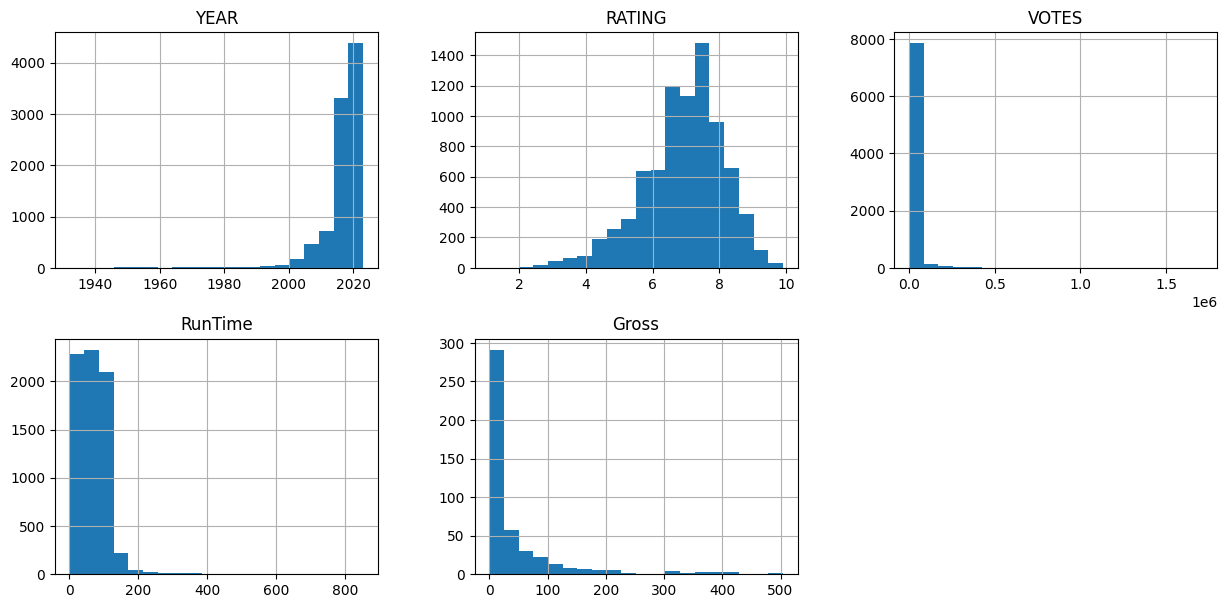

In [35]:
df.hist(
    figsize=(15,15),
    layout=(4,3),
    bins=20
    );

## 5 - ¿Hay datos duplicados?

*   **duplicated()** devuelve un booleano identificando los casos
*   **drop_duplicates()** devuelve el DataFrame sin los casos duplicados


In [36]:
df[df.duplicated()]  ## devuelve data frames duplicados

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,VOTES,RunTime,Gross,Director,Stars
6833,Mighty Little Bheem,2019,"Animation, Short, Adventure",NaN,Add a Plot,NaN,NaN,NaN,"Rajiv Chilaka,",None
6835,Mighty Little Bheem,2019,"Animation, Short, Adventure",9,Add a Plot,6,NaN,NaN,"Rajiv Chilaka,",None
6836,Mighty Little Bheem,2019,"Animation, Short, Adventure",9,Add a Plot,6,NaN,NaN,"Rajiv Chilaka,",None
6837,Mighty Little Bheem,2019,"Animation, Short, Adventure",NaN,Add a Plot,NaN,NaN,NaN,"Rajiv Chilaka,",None
6838,Mighty Little Bheem,2019,"Animation, Short, Adventure",NaN,Add a Plot,NaN,NaN,NaN,"Rajiv Chilaka,",None
...,...,...,...,...,...,...,...,...,...,...
9989,1899,2022,"Drama, History, Horror",NaN,Add a Plot,NaN,NaN,NaN,Baran bo Odar,None
9990,1899,2022,"Drama, History, Horror",NaN,Add a Plot,NaN,NaN,NaN,Baran bo Odar,None
9991,1899,2022,"Drama, History, Horror",NaN,Add a Plot,NaN,NaN,NaN,Baran bo Odar,None
9992,1899,2022,"Drama, History, Horror",NaN,Add a Plot,NaN,NaN,NaN,Baran bo Odar,None


Vemos que hay muchos duplicados, pero que algunas filas tienen información que otras no. Queremos eliminar los duplicados y además quedarnos con las que tengan valores en rating en vez de las de nulos.

In [37]:
# pd.set_option('display.max_rows', None)

In [38]:
# Creamos una columna que mire si RATING tiene valores o no
df["tiene_rating"] = df["RATING"].to_frame().count(axis=1)

# Ordenamos alfabéticamente (por defecto, ascendentemente) según nombres de películas y la columna nueva
df = df.sort_values(['MOVIES', 'tiene_rating'])

# Borramos las películas que estén más de una vez y nos quedamos con el último valor (que es donde nos aseguramos que tiene_rating=1 en el caso de que suceda)
df = df.drop_duplicates('MOVIES', keep='last')

In [39]:
# Corroboramos y no hay más duplicados

df[df.duplicated()]



,MOVIES,YEAR,GENRE,RATING,ONE-LINE,VOTES,RunTime,Gross,Director,Stars,tiene_rating


A la hora de tomar una decisión con respecto a los nulos de este DataFrame, deberíamos pensarlo en función de nuestro objetivo.

Ejercicios:

a) ¿Cuáles son los 5 directores mejor puntuados?

In [40]:
df.head()

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,VOTES,RunTime,Gross,Director,Stars,tiene_rating
8396,13 Reasons Why,2017,"Drama, Mystery, Thriller",8,"Strengthened by the struggles they've endured,...",2312,98,NaN,Brian Yorkey,"Dylan Minnette, Grace Saif, Christian Navarr...",1
9992,1899,2022,"Drama, History, Horror",NaN,Add a Plot,NaN,NaN,NaN,Baran bo Odar,None,0
9434,3Below: Tales of Arcadia,2018,"Animation, Action, Adventure",8,"Trolls, humans, gnomes and aliens alike all ma...",5,1,NaN,NaN,NaN,1
9459,50M2,2021,"Comedy, Drama, Thriller",8,A gift leads Yakup to suspect Shadow's identit...,124,64,NaN,Burak Aksak,"Engin Öztürk, Kürsat Alniaçik, Cengiz Bozkur...",1
8502,7Seeds,2019,"Animation, Action, Adventure",8,Problems persist in the ship as the spreading ...,26,24,NaN,NaN,NaN,1


In [41]:
df_2 = df.groupby("Director").agg({"MOVIES":"count", "RATING":"mean"})

In [42]:
df_2 = df_2.reset_index()

In [43]:
df_2["Director"] = df_2["Director"].replace(",","")

In [44]:
# 3153 directores
df_2.sort_values(by="MOVIES", ascending=False)

,Director,MOVIES,RATING
1278,Jay Karas,16,7
2432,"Raúl Campos,",15,6
1884,Marcus Raboy,15,7
1276,Jay Chapman,14,7
348,Bob Bryan,11,6
...,...,...,...
1153,Il Cho,1,6
1154,Ildikó Enyedi,1,8
1155,Imtiaz Ali,1,5
1156,Indi Wijay,1,NaN


In [45]:
df_2[df_2["MOVIES"]==1].shape

(2681, 3)

In [46]:
df_2=df_2[df_2["MOVIES"]>1]

In [47]:
df_2

,Director,MOVIES,RATING
18,Adam Leon,2,7
22,Adam Randall,2,6
27,Adam Wingard,2,6
33,Adrian Lyne,2,7
34,Adrian Teh,3,6
...,...,...,...
3130,Zack Snyder,4,7
3131,Zackary Adler,2,5
3133,Zak Hilditch,2,5
3141,Zoltan Paul,2,6


In [46]:
df_dir = df[df["Director"].notna()]

In [47]:
df_dir

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,VOTES,RunTime,Gross,Director,Stars,tiene_rating
8396,13 Reasons Why,2017,"Drama, Mystery, Thriller",8,"Strengthened by the struggles they've endured,...",2312,98,NaN,Brian Yorkey,"Dylan Minnette, Grace Saif, Christian Navarr...",1
9992,1899,2022,"Drama, History, Horror",NaN,Add a Plot,NaN,NaN,NaN,Baran bo Odar,None,0
9459,50M2,2021,"Comedy, Drama, Thriller",8,A gift leads Yakup to suspect Shadow's identit...,124,64,NaN,Burak Aksak,"Engin Öztürk, Kürsat Alniaçik, Cengiz Bozkur...",1
9179,800 metros,2021,Documentary,NaN,Add a Plot,NaN,NaN,NaN,León Siminiani,None,0
8543,A Suitable Boy,2020,"Drama, Romance",6,Lata makes a surprising decision about her fut...,121,58,NaN,Mira Nair,"Ishaan Khattar, Jeevan Singh Rawat, Aamir Ba...",1
...,...,...,...,...,...,...,...,...,...,...,...
4075,Çok Filim Hareketler Bunlar,2010,Comedy,4,Çok film hareketler bunlar They are a 2010 com...,4598,134,NaN,Ozan Açiktan,"Gülsüm Alkan, Ibrahim Büyükak, Emre Canpolat...",1
1256,È stata la mano di Dio,2021,Drama,NaN,Plot unknown. Set in Naples and said to be a v...,NaN,130,NaN,Paolo Sorrentino,"Filippo Scotti, Toni Servillo, Teresa Sapona...",0
3298,Òlòturé,2019,"Crime, Drama",6,A journalist goes undercover as a prostitute t...,705,106,NaN,Kenneth Gyang,"Ada Ameh, Beverly Osu, Blossom Chukwujekwu, ...",1
1106,Órbita 9,2017,"Drama, Romance, Sci-Fi",6,Helena is a young girl who spent all her life ...,7123,95,NaN,Hatem Khraiche,"Clara Lago, Álex González, Andrés Parra, Be...",1


In [48]:
df_dir.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3909 entries, 8396 to 3534
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MOVIES        3909 non-null   object 
 1   YEAR          3728 non-null   float64
 2   GENRE         3888 non-null   object 
 3   RATING        3493 non-null   float64
 4   ONE-LINE      3909 non-null   object 
 5   VOTES         3493 non-null   float64
 6   RunTime       3451 non-null   float64
 7   Gross         458 non-null    float64
 8   Director      3909 non-null   object 
 9   Stars         3723 non-null   object 
 10  tiene_rating  3909 non-null   int64  
dtypes: float64(5), int64(1), object(5)
memory usage: 366.5+ KB


In [49]:
pd.options.display.float_format = '{:,.2f}'.format

In [50]:
ranking = df_dir.groupby("Director")['RATING'].agg(lambda x: pd.to_numeric(x, errors='coerce').mean())

In [51]:
ranking.sort_values(ascending=False).head()

,RATING
Director,
Joaquim Dos Santos,9.90
"Pendleton Ward,",9.70
"Christina Manrique,",9.70
Baran bo Odar,9.70
Amanda Tapping,9.60


b) ¿Cuáles son los 5 actores que más aparecen en la base? ¿Cuáles tienen mejores películas rankeadas?

In [48]:
df

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,VOTES,RunTime,Gross,Director,Stars,tiene_rating
8396,13 Reasons Why,2017,"Drama, Mystery, Thriller",8,"Strengthened by the struggles they've endured,...",2312,98,NaN,Brian Yorkey,"Dylan Minnette, Grace Saif, Christian Navarr...",1
9992,1899,2022,"Drama, History, Horror",NaN,Add a Plot,NaN,NaN,NaN,Baran bo Odar,None,0
9434,3Below: Tales of Arcadia,2018,"Animation, Action, Adventure",8,"Trolls, humans, gnomes and aliens alike all ma...",5,1,NaN,NaN,NaN,1
9459,50M2,2021,"Comedy, Drama, Thriller",8,A gift leads Yakup to suspect Shadow's identit...,124,64,NaN,Burak Aksak,"Engin Öztürk, Kürsat Alniaçik, Cengiz Bozkur...",1
8502,7Seeds,2019,"Animation, Action, Adventure",8,Problems persist in the ship as the spreading ...,26,24,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...
673,Ófærð,2015,"Crime, Drama, Mystery",8,"In a remote town in Iceland, Police desperatel...",17309,60,NaN,NaN,NaN,1
1106,Órbita 9,2017,"Drama, Romance, Sci-Fi",6,Helena is a young girl who spent all her life ...,7123,95,NaN,Hatem Khraiche,"Clara Lago, Álex González, Andrés Parra, Be...",1
2580,Ôkami to kôshinryô,2008,"Animation, Adventure, Fantasy",8,Kraft Lawrence goes from town to town to make ...,3959,24,NaN,NaN,NaN,1
3534,Öldür Beni Sevgilim,2019,"Comedy, Romance",4,Can the excitement of the national lottery sav...,1568,104,NaN,Senol Sönmez,"Murat Boz, Seda Bakan, Açelya Topaloglu, Öz...",1


In [49]:
df_act = df

In [50]:
df_act[["Actor 1", "Actor 2", "Actor 3", "Actor 4"]] = df_act["Stars"].str.split(",", expand=True)

In [51]:
df_act = df_act[df_act["Stars"].notna()]

In [52]:
df_act.drop("Stars", axis=1, inplace=True)

<ipython-input-52-87eb7b8a0f1f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_act.drop("Stars", axis=1, inplace=True)


In [53]:
df_act

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,VOTES,RunTime,Gross,Director,tiene_rating,Actor 1,Actor 2,Actor 3,Actor 4
8396,13 Reasons Why,2017,"Drama, Mystery, Thriller",8,"Strengthened by the struggles they've endured,...",2312,98,NaN,Brian Yorkey,1,Dylan Minnette,Grace Saif,Christian Navarro,Alisha Boe
9459,50M2,2021,"Comedy, Drama, Thriller",8,A gift leads Yakup to suspect Shadow's identit...,124,64,NaN,Burak Aksak,1,Engin Öztürk,Kürsat Alniaçik,Cengiz Bozkurt,Aybüke Pusat
8543,A Suitable Boy,2020,"Drama, Romance",6,Lata makes a surprising decision about her fut...,121,58,NaN,Mira Nair,1,Ishaan Khattar,Jeevan Singh Rawat,Aamir Bashir,Shubham Saraf
8276,After Life,2019,"Comedy, Drama",9,"Grieving over another loss, Tony asks his frie...",2245,30,NaN,Ricky Gervais,1,Ricky Gervais,Tom Basden,Tony Way,Diane Morgan
8044,Age of Samurai: Battle for Japan,2021,"Documentary, Action, Adventure",7,A dying Hideyoshi appoints five regents to gov...,138,44,NaN,Stephen Scott,1,Hiro Kanagawa,Hayate Masao,Hideaki Itô,Yohei Matsukado
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4075,Çok Filim Hareketler Bunlar,2010,Comedy,4,Çok film hareketler bunlar They are a 2010 com...,4598,134,NaN,Ozan Açiktan,1,Gülsüm Alkan,Ibrahim Büyükak,Emre Canpolat,Murat Eken
1256,È stata la mano di Dio,2021,Drama,NaN,Plot unknown. Set in Naples and said to be a v...,NaN,130,NaN,Paolo Sorrentino,0,Filippo Scotti,Toni Servillo,Teresa Saponangelo,Marlon Joubert
3298,Òlòturé,2019,"Crime, Drama",6,A journalist goes undercover as a prostitute t...,705,106,NaN,Kenneth Gyang,1,Ada Ameh,Beverly Osu,Blossom Chukwujekwu,Bukola Oladipupo
1106,Órbita 9,2017,"Drama, Romance, Sci-Fi",6,Helena is a young girl who spent all her life ...,7123,95,NaN,Hatem Khraiche,1,Clara Lago,Álex González,Andrés Parra,Belén Rueda


In [54]:
df_act = df_act.melt(id_vars=['MOVIES', 'YEAR', 'GENRE', 'RATING', 'ONE-LINE', 'VOTES', 'RunTime',
       'Gross', 'Director', "tiene_rating"])

In [55]:
df_act

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,VOTES,RunTime,Gross,Director,tiene_rating,variable,value
0,13 Reasons Why,2017,"Drama, Mystery, Thriller",8,"Strengthened by the struggles they've endured,...",2312,98,NaN,Brian Yorkey,1,Actor 1,Dylan Minnette
1,50M2,2021,"Comedy, Drama, Thriller",8,A gift leads Yakup to suspect Shadow's identit...,124,64,NaN,Burak Aksak,1,Actor 1,Engin Öztürk
2,A Suitable Boy,2020,"Drama, Romance",6,Lata makes a surprising decision about her fut...,121,58,NaN,Mira Nair,1,Actor 1,Ishaan Khattar
3,After Life,2019,"Comedy, Drama",9,"Grieving over another loss, Tony asks his frie...",2245,30,NaN,Ricky Gervais,1,Actor 1,Ricky Gervais
4,Age of Samurai: Battle for Japan,2021,"Documentary, Action, Adventure",7,A dying Hideyoshi appoints five regents to gov...,138,44,NaN,Stephen Scott,1,Actor 1,Hiro Kanagawa
...,...,...,...,...,...,...,...,...,...,...,...,...
14887,Çok Filim Hareketler Bunlar,2010,Comedy,4,Çok film hareketler bunlar They are a 2010 com...,4598,134,NaN,Ozan Açiktan,1,Actor 4,Murat Eken
14888,È stata la mano di Dio,2021,Drama,NaN,Plot unknown. Set in Naples and said to be a v...,NaN,130,NaN,Paolo Sorrentino,0,Actor 4,Marlon Joubert
14889,Òlòturé,2019,"Crime, Drama",6,A journalist goes undercover as a prostitute t...,705,106,NaN,Kenneth Gyang,1,Actor 4,Bukola Oladipupo
14890,Órbita 9,2017,"Drama, Romance, Sci-Fi",6,Helena is a young girl who spent all her life ...,7123,95,NaN,Hatem Khraiche,1,Actor 4,Belén Rueda


In [56]:
df_act=df_act.rename(columns={"value":"Actor"})

In [57]:
df_act["Actor"]=df_act["Actor"].str.strip()

In [58]:
df_act["Actor"].value_counts().head()

,count
Actor,
Jakob Eklund,18
Adam Sandler,13
Liam Neeson,11
Mario Casas,10
Bruce Willis,10


In [59]:
df_act

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,VOTES,RunTime,Gross,Director,tiene_rating,variable,Actor
0,13 Reasons Why,2017,"Drama, Mystery, Thriller",8,"Strengthened by the struggles they've endured,...",2312,98,NaN,Brian Yorkey,1,Actor 1,Dylan Minnette
1,50M2,2021,"Comedy, Drama, Thriller",8,A gift leads Yakup to suspect Shadow's identit...,124,64,NaN,Burak Aksak,1,Actor 1,Engin Öztürk
2,A Suitable Boy,2020,"Drama, Romance",6,Lata makes a surprising decision about her fut...,121,58,NaN,Mira Nair,1,Actor 1,Ishaan Khattar
3,After Life,2019,"Comedy, Drama",9,"Grieving over another loss, Tony asks his frie...",2245,30,NaN,Ricky Gervais,1,Actor 1,Ricky Gervais
4,Age of Samurai: Battle for Japan,2021,"Documentary, Action, Adventure",7,A dying Hideyoshi appoints five regents to gov...,138,44,NaN,Stephen Scott,1,Actor 1,Hiro Kanagawa
...,...,...,...,...,...,...,...,...,...,...,...,...
14887,Çok Filim Hareketler Bunlar,2010,Comedy,4,Çok film hareketler bunlar They are a 2010 com...,4598,134,NaN,Ozan Açiktan,1,Actor 4,Murat Eken
14888,È stata la mano di Dio,2021,Drama,NaN,Plot unknown. Set in Naples and said to be a v...,NaN,130,NaN,Paolo Sorrentino,0,Actor 4,Marlon Joubert
14889,Òlòturé,2019,"Crime, Drama",6,A journalist goes undercover as a prostitute t...,705,106,NaN,Kenneth Gyang,1,Actor 4,Bukola Oladipupo
14890,Órbita 9,2017,"Drama, Romance, Sci-Fi",6,Helena is a young girl who spent all her life ...,7123,95,NaN,Hatem Khraiche,1,Actor 4,Belén Rueda


In [60]:
df_act.groupby("Actor")["RATING"].mean().sort_values(ascending=False).head()

,RATING
Actor,
Michaela Jill Murphy,10
Zach Tyler,10
Jack De Sena,10
Aimee Carrero,10
Sebastian Rudolph,10


c) ¿Cuáles son las películas de drama mejor puntuadas?

In [61]:
df_gen = df

In [62]:
df.columns

Index(['MOVIES', 'YEAR', 'GENRE', 'RATING', 'ONE-LINE', 'VOTES', 'RunTime',
       'Gross', 'Director', 'Stars', 'tiene_rating', 'Actor 1', 'Actor 2',
       'Actor 3', 'Actor 4'],
      dtype='object')

In [63]:
df_gen = df_gen[df_gen["GENRE"].notna()]

In [64]:
df_drama = df_gen[df_gen["GENRE"].str.contains("Drama")]

In [65]:
df_drama.sort_values("RATING", ascending=False).head()["MOVIES"]

,MOVIES
8767,Dark
7641,BoJack Horseman
7792,Anne
7870,The Dragon Prince
6915,Cobra Kai


También podríamos separarlo con get_dummies()

In [66]:
df_gen

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,VOTES,RunTime,Gross,Director,Stars,tiene_rating,Actor 1,Actor 2,Actor 3,Actor 4
8396,13 Reasons Why,2017,"Drama, Mystery, Thriller",8,"Strengthened by the struggles they've endured,...",2312,98,NaN,Brian Yorkey,"Dylan Minnette, Grace Saif, Christian Navarr...",1,Dylan Minnette,Grace Saif,Christian Navarro,Alisha Boe
9992,1899,2022,"Drama, History, Horror",NaN,Add a Plot,NaN,NaN,NaN,Baran bo Odar,None,0,None,None,None,None
9434,3Below: Tales of Arcadia,2018,"Animation, Action, Adventure",8,"Trolls, humans, gnomes and aliens alike all ma...",5,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
9459,50M2,2021,"Comedy, Drama, Thriller",8,A gift leads Yakup to suspect Shadow's identit...,124,64,NaN,Burak Aksak,"Engin Öztürk, Kürsat Alniaçik, Cengiz Bozkur...",1,Engin Öztürk,Kürsat Alniaçik,Cengiz Bozkurt,Aybüke Pusat
8502,7Seeds,2019,"Animation, Action, Adventure",8,Problems persist in the ship as the spreading ...,26,24,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673,Ófærð,2015,"Crime, Drama, Mystery",8,"In a remote town in Iceland, Police desperatel...",17309,60,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
1106,Órbita 9,2017,"Drama, Romance, Sci-Fi",6,Helena is a young girl who spent all her life ...,7123,95,NaN,Hatem Khraiche,"Clara Lago, Álex González, Andrés Parra, Be...",1,Clara Lago,Álex González,Andrés Parra,Belén Rueda
2580,Ôkami to kôshinryô,2008,"Animation, Adventure, Fantasy",8,Kraft Lawrence goes from town to town to make ...,3959,24,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
3534,Öldür Beni Sevgilim,2019,"Comedy, Romance",4,Can the excitement of the national lottery sav...,1568,104,NaN,Senol Sönmez,"Murat Boz, Seda Bakan, Açelya Topaloglu, Öz...",1,Murat Boz,Seda Bakan,Açelya Topaloglu,Özgür Emre Yildirim


## Interpolación de series de tiempo.

Veamos un ejemplo en el que queremos realizar interpolaciones para las series temporales, para así obtener nuevos puntos partiendo del conocimiento de un conjunto de puntos.

Comparemos cuatro activos: acciones, bonos, oro y petróleo.

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

filename = 'https://storage.googleapis.com/humai-datasets/aws_s3/analisis_de_datos/6_Validacion/asset_classes.csv'
import urllib.request
urllib.request.urlretrieve(filename, "asset_classes.csv")

('asset_classes.csv', <http.client.HTTPMessage at 0x7cdd9bec1c90>)

In [68]:
prices = pd.read_csv('asset_classes.csv', parse_dates=['DATE'], index_col='DATE')

In [69]:
prices=prices.astype(int)

In [70]:
prices = prices.apply(lambda x: x.sample(frac=0.25))

In [71]:
prices

,SP500,Bonds,Gold,Oil
DATE,,,,
2007-07-03,1524,NaN,NaN,71
2007-07-06,NaN,399,NaN,NaN
2007-07-11,1518,NaN,NaN,NaN
2007-07-12,NaN,400,NaN,NaN
2007-07-13,1552,NaN,667,NaN
...,...,...,...,...
2017-06-20,2437,NaN,NaN,43
2017-06-21,NaN,622,NaN,42
2017-06-22,NaN,622,NaN,42


In [72]:
prices[prices.isna().any(axis=1)]

,SP500,Bonds,Gold,Oil
DATE,,,,
2007-07-03,1524,NaN,NaN,71
2007-07-06,NaN,399,NaN,NaN
2007-07-11,1518,NaN,NaN,NaN
2007-07-12,NaN,400,NaN,NaN
2007-07-13,1552,NaN,667,NaN
...,...,...,...,...
2017-06-20,2437,NaN,NaN,43
2017-06-21,NaN,622,NaN,42
2017-06-22,NaN,622,NaN,42


In [73]:
prices_16 = prices[prices.index.year==2016]

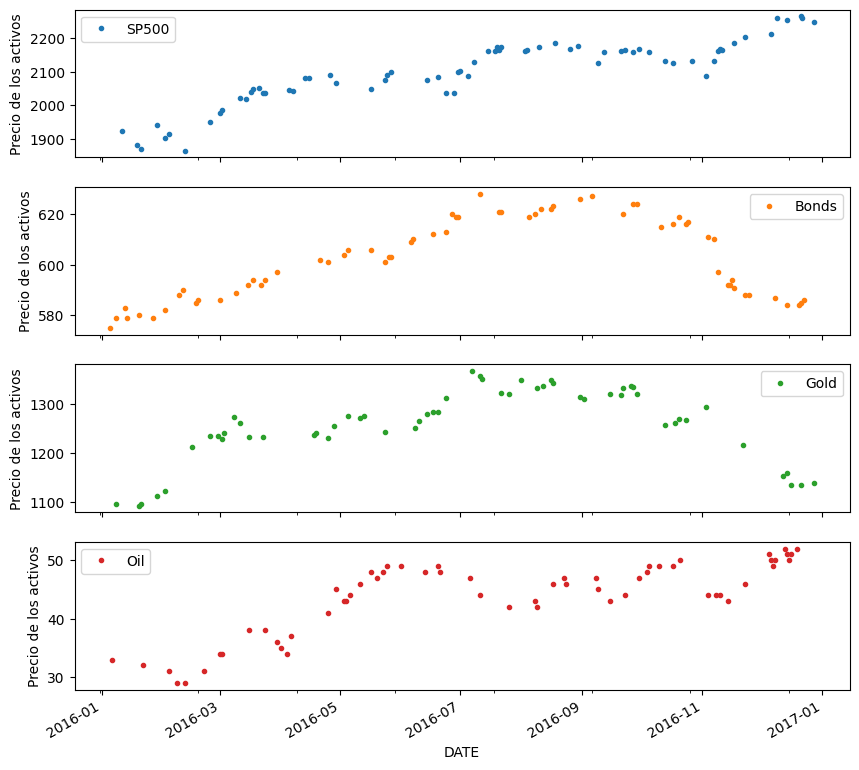

In [74]:
ejes = prices_16.plot(marker='.', linestyle='None',figsize=(10,10),subplots=True)
for eje in ejes:
  eje.set_ylabel('Precio de los activos')


Podríamos imputar los datos con un fillna()

In [75]:
prices_b = prices.fillna(method='bfill')

<ipython-input-75-50b789c6c1a8>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prices_b = prices.fillna(method='bfill')


In [76]:
prices_b#.Gold.plot()

,SP500,Bonds,Gold,Oil
DATE,,,,
2007-07-03,1524,399,667,71
2007-07-06,1518,399,667,74
2007-07-11,1518,400,667,74
2007-07-12,1552,400,667,74
2007-07-13,1552,406,667,74
...,...,...,...,...
2017-06-20,2437,622,1256,43
2017-06-21,2439,622,1256,42
2017-06-22,2439,622,1256,42


In [80]:
import pandas as pd
import matplotlib.pyplot as  plt
from urllib.request import urlretrieve

# Install and import seaborn
!pip install seaborn
import seaborn as sns

# Set the style using seaborn's set_theme function or plt.style.use with the updated name
sns.set_theme() # This applies the default seaborn style
# Or
# plt.style.use('seaborn-v0_8') # Use this if you want a specific seaborn version's style

linear = prices_16.interpolate(method='linear')  ## interpolaciones con metodos
quadratic = prices_16.interpolate(method='quadratic')
nearest = prices_16.interpolate(method='nearest')

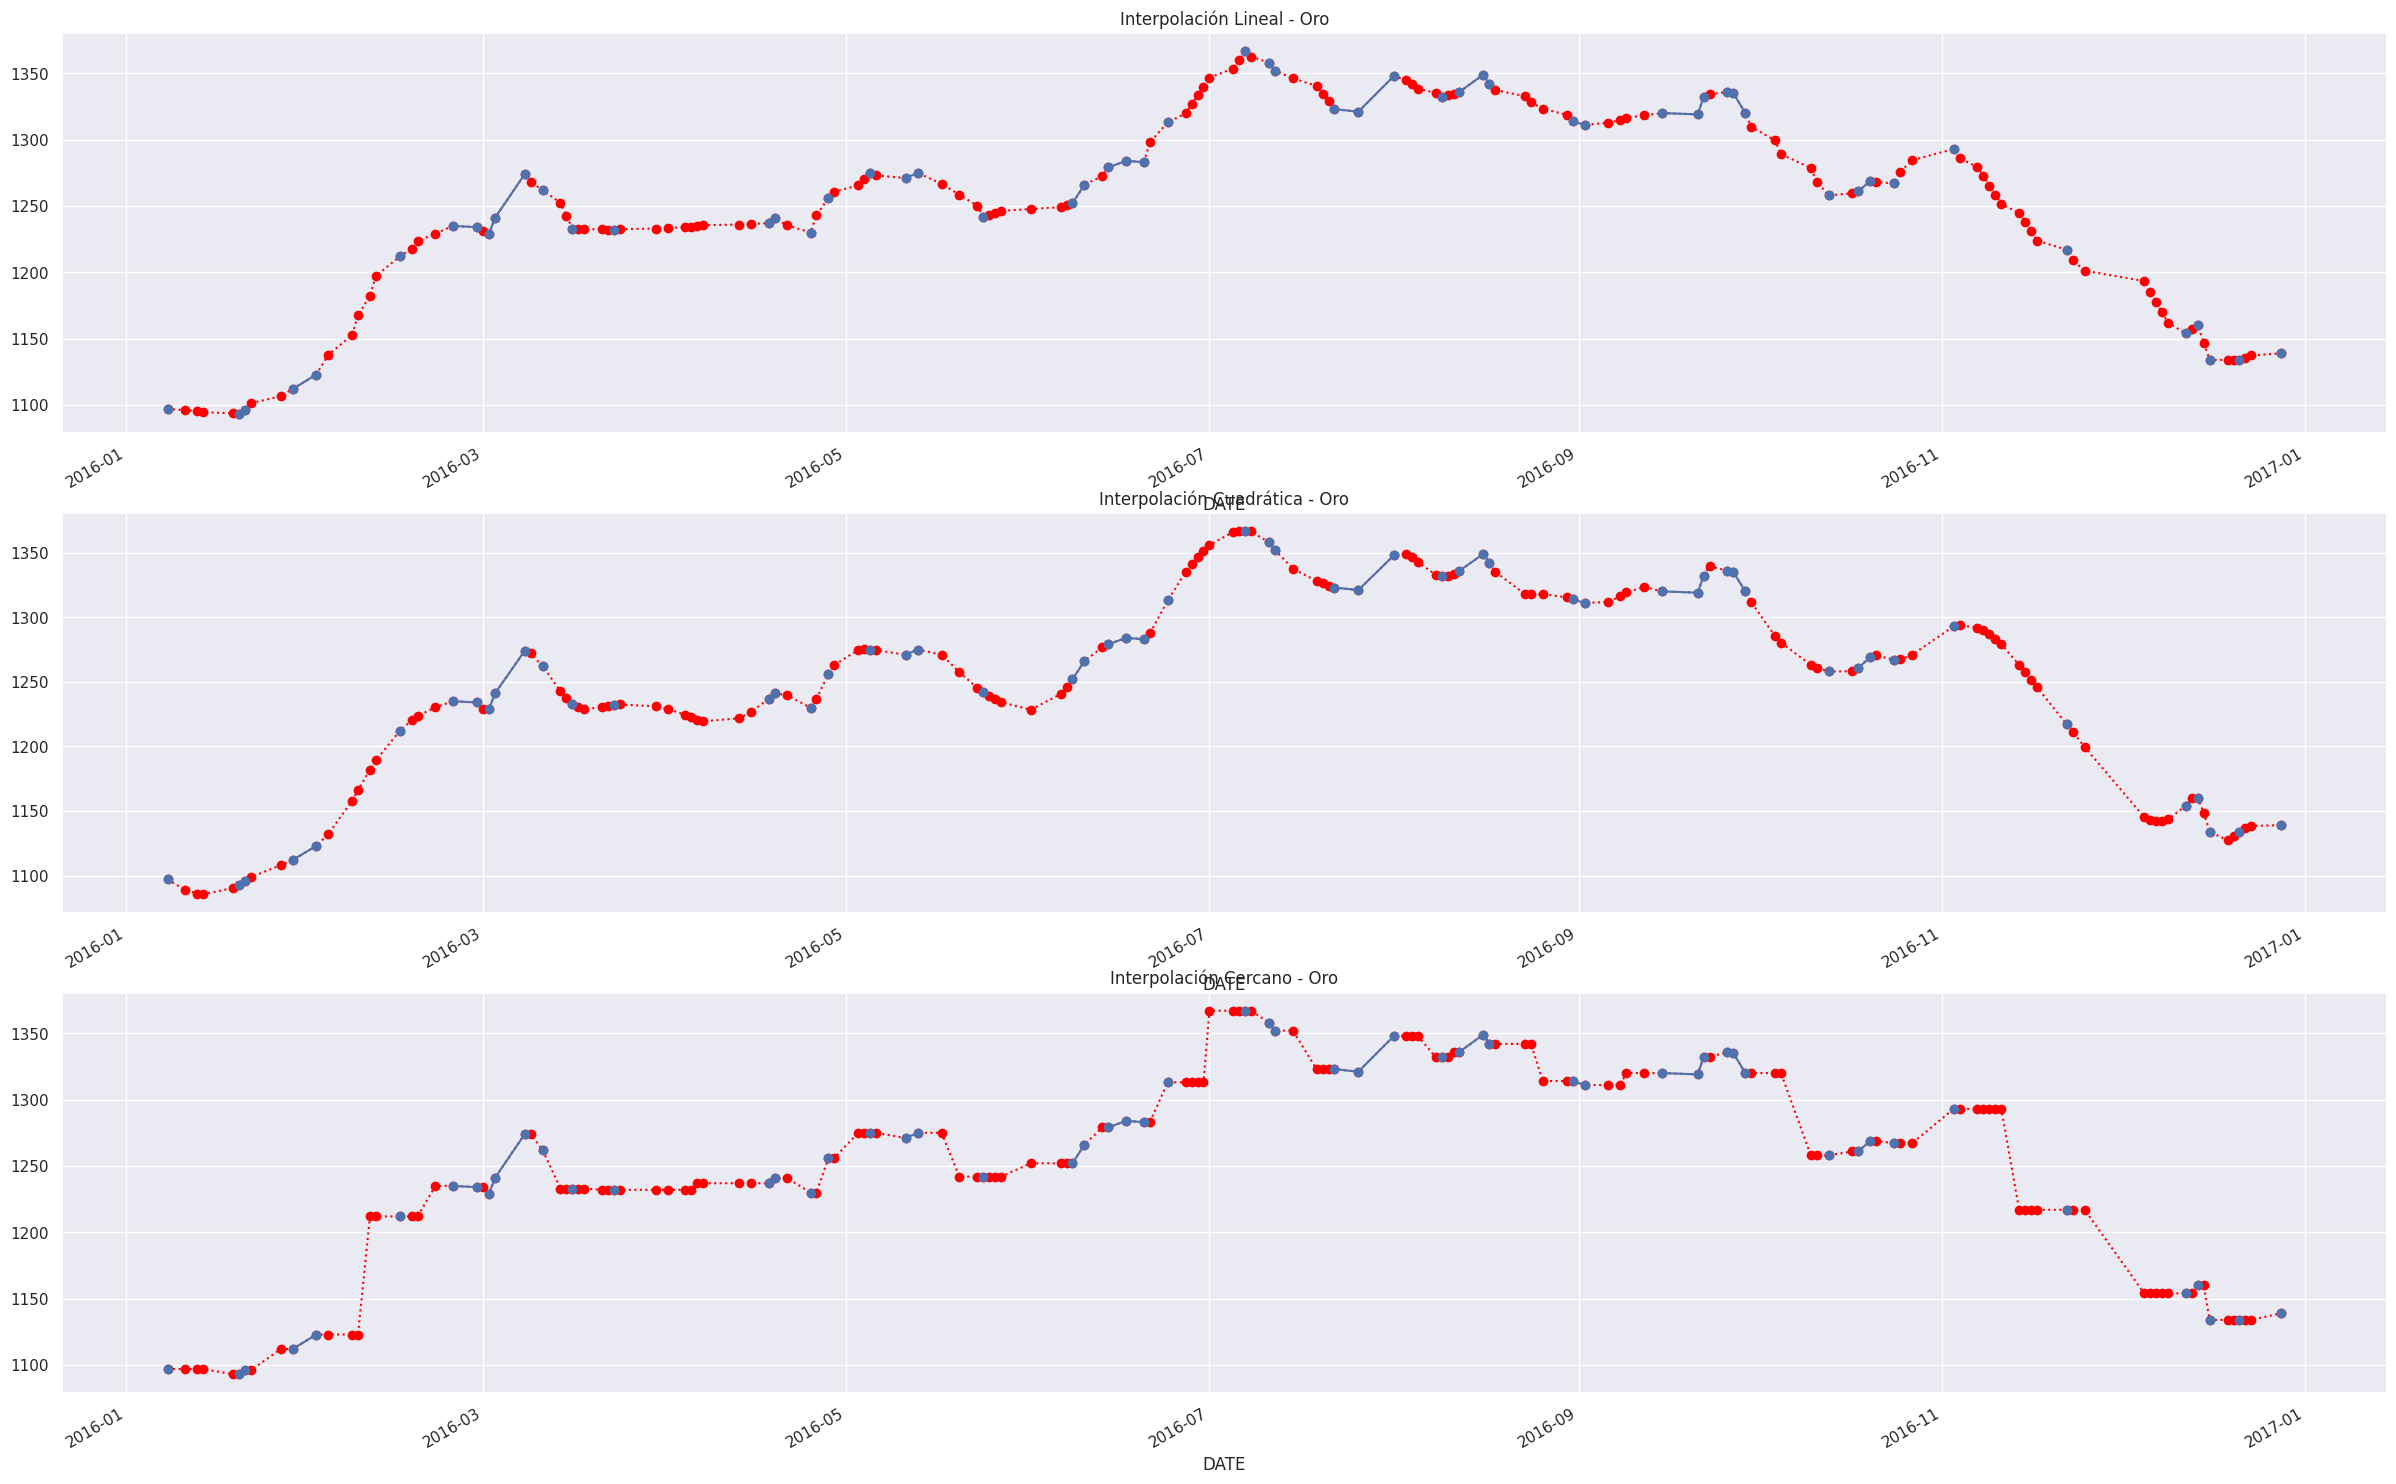

In [79]:
# Set nrows to 3 and ncols to 1
fig, axes = plt.subplots(3, 1, figsize=(30, 20))

# Create a dictionary of interpolations
interpolations = {'Interpolación Lineal': linear, 'Interpolación Cuadrática': quadratic,
                  'Interpolación Cercano': nearest}

# Loop over axes and interpolations
for ax, df_key in zip(axes, interpolations):
  # Select and also set the title for a DataFrame
  interpolations[df_key].Gold.plot(color='red', marker='o',
                                 linestyle='dotted', ax=ax)
  prices_16.Gold.plot(title=df_key + ' - Oro', marker='o', ax=ax)

plt.show()

### podemos usar una red neuronal profunda para modelar los datos de la serie de tiempo

## Ley de Humedales


## Extracción de los datos Web
Datos sobre legisladores y sus posturas frente a la Ley de Humedales.

Gracias a https://activaelcongreso.ar por la data.

Pasos para el scraping:
- Identificar el tema a investigar
- Identificar una fuente de datos (activaelcongreso.ar)
- Dentro del sitio, ver dónde se renderizan los datos:
https://activaelcongreso.ar/p/Ley_de_Humedales_Ya/politicos
- Aplicar lo que se ve en la clase de APIs Ocultas (agregar link):
  - Abrimos ChromeDevTools
  - Vamos a la pestaña Network
  - Identificamos (podemos usar el buscador) los requests que contienen la info
  - Copiamos el request como cURL, y usamos algo como https://curlconverter.com/ para convertirlo a Python
  - Identificamos la parte central del request, quitando los cookies y headers no esenciales

Con eso podemos bajar los distintos jsons que necesitamos, y unirlos para armar la tabla con datos útiles.

In [81]:
# Bajamos datos encontrados en distintos requests

import requests

# el sitio web utilizado en la grabación del curso no funciona actualmente. A continuación cuentan con un url nuevo, muy similar al utilizado en clase.
# A los fines explicativos de la clase, no hay diferencias en el uso de un url distinto

url = 'https://www.senado.gob.ar/micrositios/DatosAbiertos/ExportarListadoSenadores/json'

json_data = {
    'type': 'Partido',
    'action': 'get',
    'params': {},
}

partidos = requests.post(url).json()
partidos = partidos['table']['rows']
partidos[0]

{'ID': '546',
 'BLOQUE': 'UNIÓN CÍVICA RADICAL',
 'APELLIDO': 'ABAD',
 'NOMBRE': 'MAXIMILIANO',
 'PROVINCIA': 'BUENOS AIRES',
 'PARTIDO O ALIANZA': 'JUNTOS POR EL CAMBIO',
 'D_LEGAL': '2023-12-10',
 'C_LEGAL': '2029-12-09',
 'D_REAL': '2023-12-10',
 'C_REAL': 'Sin Datos',
 'EMAIL': 'maximiliano.abad@senado.gob.ar',
 'TELEFONO': '1045 / 1046',
 'FOTO': 'https://www.senado.gob.ar/bundles/senadosenadores/images/fsena/546.gif',
 'FACEBOOK': 'https://www.facebook.com/maxiabad?mibextid=9R9pXO',
 'TWITTER': 'https://x.com/maxiabad?s=11',
 'INSTAGRAM': 'https://www.instagram.com/maxi.abad?igsh=MXc2YzF3YWduc3hneA==',
 'YOUTUBE': ''}

## Pydantic


Cuando armamos aplicaciones con distintos componentes, es útil ir más allá del **tipado dinámico** y definir los típos de datos y **esquemas** que esperamos. Definamos un primer ejemplo de juguete:

https://docs.pydantic.dev/latest/install/


## Definimos que pydantic que explicita los campos y propiedades de cada observacion tenga
tres claves id= ge--greather o equaul
nombre  string
altura float

In [82]:
from typing import Optional
from pydantic import BaseModel, Field

class SuperDict(BaseModel):
    '''
    Field nos permite especificar caracteristicas del campo, como descripcion o restricciones.
    Podemos dejar campos como opcionales con Optional.
    '''

    id: int = Field(ge=1)
    nombre: str = Field(min_length=1, max_length=30)
    altura: Optional[float] = Field(ge=0, le=300, description="Altura en cm.")

In [109]:
SuperDict(id=1, nombre='Ernesto', altura=170.0)  ### instanciamos un Superdiccionario con id, nombre y altura

SuperDict(id=1, nombre='Ernesto', altura=170.0)

In [110]:
caso = {"id": 2, "nombre": ""}  ## instanciamos observacion con error de validacion

In [85]:
from pydantic import ValidationError

try:
    SuperDict(**caso)
except ValidationError as e:
    print(e)

2 validation errors for SuperDict
nombre
  String should have at least 1 character [type=string_too_short, input_value='', input_type=str]
    For further information visit https://errors.pydantic.dev/2.10/v/string_too_short
altura
  Field required [type=missing, input_value={'id': 2, 'nombre': ''}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/missing


In [86]:
url = 'https://www.senado.gob.ar/micrositios/DatosAbiertos/ExportarListadoSenadores/json'

json_data = {
    'type': 'Partido',
    'action': 'get',
    'params': {},
}

partidos = requests.post(url).json()
partidos = partidos['table']['rows']
partidos[0]

{'ID': '546',
 'BLOQUE': 'UNIÓN CÍVICA RADICAL',
 'APELLIDO': 'ABAD',
 'NOMBRE': 'MAXIMILIANO',
 'PROVINCIA': 'BUENOS AIRES',
 'PARTIDO O ALIANZA': 'JUNTOS POR EL CAMBIO',
 'D_LEGAL': '2023-12-10',
 'C_LEGAL': '2029-12-09',
 'D_REAL': '2023-12-10',
 'C_REAL': 'Sin Datos',
 'EMAIL': 'maximiliano.abad@senado.gob.ar',
 'TELEFONO': '1045 / 1046',
 'FOTO': 'https://www.senado.gob.ar/bundles/senadosenadores/images/fsena/546.gif',
 'FACEBOOK': 'https://www.facebook.com/maxiabad?mibextid=9R9pXO',
 'TWITTER': 'https://x.com/maxiabad?s=11',
 'INSTAGRAM': 'https://www.instagram.com/maxi.abad?igsh=MXc2YzF3YWduc3hneA==',
 'YOUTUBE': ''}

In [87]:
partidos

[{'ID': '546',
  'BLOQUE': 'UNIÓN CÍVICA RADICAL',
  'APELLIDO': 'ABAD',
  'NOMBRE': 'MAXIMILIANO',
  'PROVINCIA': 'BUENOS AIRES',
  'PARTIDO O ALIANZA': 'JUNTOS POR EL CAMBIO',
  'D_LEGAL': '2023-12-10',
  'C_LEGAL': '2029-12-09',
  'D_REAL': '2023-12-10',
  'C_REAL': 'Sin Datos',
  'EMAIL': 'maximiliano.abad@senado.gob.ar',
  'TELEFONO': '1045 / 1046',
  'FOTO': 'https://www.senado.gob.ar/bundles/senadosenadores/images/fsena/546.gif',
  'FACEBOOK': 'https://www.facebook.com/maxiabad?mibextid=9R9pXO',
  'TWITTER': 'https://x.com/maxiabad?s=11',
  'INSTAGRAM': 'https://www.instagram.com/maxi.abad?igsh=MXc2YzF3YWduc3hneA==',
  'YOUTUBE': ''},
 {'ID': '564',
  'BLOQUE': 'LA LIBERTAD AVANZA',
  'APELLIDO': 'ABDALA',
  'NOMBRE': 'BARTOLOMÉ ESTEBAN',
  'PROVINCIA': 'SAN LUIS',
  'PARTIDO O ALIANZA': 'ALIANZA LA LIBERTAD AVANZA',
  'D_LEGAL': '2023-12-10',
  'C_LEGAL': '2029-12-09',
  'D_REAL': '2023-12-10',
  'C_REAL': 'Sin Datos',
  'EMAIL': 'bartolome.abdala@senado.gob.ar',
  'TELEFONO': 

Podemos validar el dato que esperamos con un esquema de pydantic.

### Ejemplo Bloques

In [88]:
class PartidoID(BaseModel):
    ID: int
    FOTO: str
    PARTIDO: str = Field(alias='PARTIDO O ALIANZA')
# En el JSON tenemos el campo 'PARTIDO O ALIANZA' pero no podemos tener espacios en una variable, así que le creamos un alias que haga el match con el nombre que está en el JSON.

In [89]:
# Podemos validar todos los bloques que nos trajo la API
partidos_validados = [PartidoID(**b) for b in partidos][:5]

Podemos hacer validaciones personalizadas, como validar que el campo de  `foto` termine con `jpg` usando el **decorador `validator`**

In [112]:
from pydantic import BaseModel, validator

class PartidoID(BaseModel):
    ID: int
    FOTO: str
    PARTIDO: str = Field(alias='PARTIDO O ALIANZA')

    @validator('FOTO')
    def validate_photo(cls, v):  ## funcion validadora que va a fijarse que el campo cumpla con la propiedad que se espera
        assert v.endswith('gif'), 'No termina con JPG'
        return v

<ipython-input-112-a5a6d229e546>:8: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  @validator('FOTO')


O validar que el campo "nombre" pertenezca a una lista de nombres predefinidos

### podemos hacer una enumeracion de valores nombre = bloque con masyuculas

In [91]:
from typing import List
from enum import Enum

class Partido(Enum):
    FRENTE_DE_TODOS = 'Frente de Todos'
    PRO = 'PRO'
    PRODUCCIÓN_Y_TRABAJO = 'Producción y Trabajo'
    UNIDAD_Y_EQUIDAD_POR_SAN_LUIS = 'Unidad y Equidad por San Luis'
    UNIÓN_CÍVICA_RADICAL = 'Unión Cívica Radical'
    PARTIDO_POR_LA_JUSTICIA_SOCIAL = 'Partido por la Justicia Social'
    JUSTICIALISTA = 'Justicialista'
    CONSENSO_FEDERAL = 'Consenso Federal'
    CÓRDOBA_FEDERAL = 'Córdoba Federal'
    COALICIÓN_CÍVICA = 'Coalición Cívica'
    FRENTE_PROGRESISTA_CÍVICO_Y_SOCIAL = 'Frente Progresista Cívico y Social'
    PTS_FRENTE_DE_IZQUIERDA = 'PTS - Frente de Izquierda'
    SOCIALISTA = 'Socialista'
    JUNTOS_SOMOS_RIO_NEGRO = 'Juntos Somos Rio Negro'
    JUNTOS_POR_EL_CAMBIO = 'JUNTOS POR EL CAMBIO'
    FRENTE_DE_IZQUIERDA_Y_DE_LOS_TRABAJADORES = 'Frente de Izquierda y de los Trabajadores - Unidad'
    FRENTE_DE_LA_CONCORDIA_MISIONERO = 'Frente de la Concordia Misionero'
    MOVIMIENTO_POPULAR_NEUQUINO = 'Movimiento Popular Neuquino'
    ACCION_FEDERAL = 'Acción Federal'
    FRENTE_CÍVICO_Y_SOCIAL_DE_CATAMARCA = 'Frente Cívico y Social de Catamarca'
    FUERZA_CÍVICA_RIOJANA = 'Fuerza Cívica Riojana'
    AVANZAR_SAN_LUIS = 'Avanzar San Luis'
    SANTA_FE_FEDERAL = 'Santa Fe Federal'
    JUSTICIALISTA_8_DE_OCTUBRE = 'Justicialista 8 de Octubre'
    MISIONES = 'Misiones '
    UNIDAD_FEDERAL_PARA_EL_DESARROLLO = 'Unidad Federal para el Desarrollo'
    AVANZA_LIBERTAD = 'Avanza Libertad'
    AHORA_PATRIA = 'Ahora Patria'
    IDENTIDAD_BONAERENSE_ = 'Identidad Bonaerense '
    EVOLUCIÓN_RADICAL = 'Evolución Radical'
    ENCUENTRO_FEDERAL = 'Encuentro Federal'
    CREO = 'Creo'
    IZQUIERDA_SOCIALISTA_FRENTE_DE_IZQUIERDA = 'Izquierda Socialista - Frente de Izquierda'
    LA_LIBERTAD_AVANZA = 'La Libertad Avanza'
    UNIDOS_POR_SAN_LUIS = 'Unidos por San Luis'
    PARTIDO_OBRERO_FRENTE_DE_IZQUIERDA_Y_DE_LOS_TRABAJADORES_UNIDAD = 'Partido Obrero - Frente de Izquierda y de los Trabajadores - Unidad'
    PTS_FRENTE_DE_IZQUIERDA_DE_TRABAJADORES_UNIDAD = 'PTS - Frente de Izquierda de Trabajadores - Unidad'
    REPUBLICANOS_UNIDOS_ = 'Republicanos Unidos '
    SIN_BLOQUE = 'Sin Bloque'
    SER_SOMOS_ENERGÍA_PARA_RENOVAR = 'SER - Somos Energía para Renovar'
    UNIDAD_Y_EQUIDAD_FEDERAL = 'Unidad y Equidad Federal'

### Ejemplo con Enum

In [92]:
from pydantic import validator

class PartidoID(BaseModel):
    ID: int
    FOTO: str
    # Bloque ahora solo puede ser alguno de los valores de arriba
    PARTIDO: Partido = Field(alias='PARTIDO O ALIANZA')
    #color: str

    @validator('FOTO')
    def validate_photo(cls, v):
      assert v.endswith('gif'), 'No termina con JPG'
      return v

<ipython-input-92-ddaed6611fb7>:10: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  @validator('FOTO')


In [93]:
PartidoID(**partidos[0])

PartidoID(ID=546, FOTO='https://www.senado.gob.ar/bundles/senadosenadores/images/fsena/546.gif', PARTIDO=<Partido.JUNTOS_POR_EL_CAMBIO: 'JUNTOS POR EL CAMBIO'>)

In [94]:
partido1 = {'ID': '546',
          'FOTO': 'https://www.senado.gob.ar/bundles/senadosenadores/images/fsena/546.gif',
          'PARTIDO':'JUNTOS POR EL PAIS'}

In [114]:
####PartidoID(**partido1[0])

¿Cómo podemos hacer para normalizar y reparar casos como este? Veremos cómo hacerlo con **búsqueda difusa de strings**

### Ejercicio Pydantic

1. Crear un esquema de PyDantic que valide el siguiente JSON de `Politico`.
2. Crear otro esquema para `Sexo` que valide que el número en ese campo sea uno de los dos permitidos (0,1). Hacer que `Politico` tenga un campo `Sexo`.
3. Agregar validación para la fecha de nacimiento y para el mail (se podría pensar una validación usando REGEX para el mail)

In [117]:
# prompt: Agregar validación para la fecha de nacimiento y para el mail (se podría pensar una validación usando REGEX para el mail)

from datetime import date, datetime
import re
from pydantic import BaseModel, Field, validator
from typing import Optional
from enum import Enum


class Sexo(Enum):
    MASCULINO = 0
    FEMENINO = 1


class Politico(BaseModel):
    ID: int
    FOTO: str
    NOMBRE: str
    PARTIDO: str
    Provincia: str
    EMAIL: Optional[str]
    FechaNacimiento: Optional[date]
    Sexo: Sexo

    @validator("EMAIL")
    def validate_email(cls, v):
        if v:
            if not re.match(r"[^@]+@[^@]+\.[^@]+", v):
                raise ValueError("Invalid email format")
        return v

    @validator("FechaNacimiento")
    def validate_birthdate(cls, v):
      if v:
        if v > date.today():
            raise ValueError("Birth date cannot be in the future")
      return v


<ipython-input-117-913167244558>:25: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  @validator("EMAIL")
<ipython-input-117-913167244558>:32: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  @validator("FechaNacimiento")


In [116]:
# prompt: Crear otro esquema para Sexo que valide que el número en ese campo sea uno de los dos permitidos (0,1). Hacer que Politico tenga un campo Sexo.

from datetime import date
from pydantic import BaseModel, Field, validator, ValidationError
from typing import Optional
from enum import Enum

class Sexo(int, Enum):
    MASCULINO = 0
    FEMENINO = 1

class Politico(BaseModel):
    nombre: str
    apellido: str
    fecha_nacimiento: date
    email: str
    sexo: Sexo

    @validator('email')
    def validate_email(cls, v):
        if "@" not in v or "." not in v:
            raise ValueError("Invalid email format")
        return v


<ipython-input-116-da1578ecbc26>:19: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  @validator('email')


In [115]:
# prompt: Crear un esquema de PyDantic que valide el siguiente JSON de Politico.

from pydantic import BaseModel, Field, validator
from datetime import date
from typing import Optional
import re

class Sexo(BaseModel):
    id: int = Field(ge=0, le=1)

class Politico(BaseModel):
    id: int
    nombre: str
    apellido: str
    fecha_nacimiento: date
    email: Optional[str] = None
    sexo: Sexo

    @validator('email')
    def validate_email(cls, v):
        if v:
            regex = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
            if not re.fullmatch(regex, v):
                raise ValueError("Invalid email address")
        return v


<ipython-input-115-9b0d771bd84c>:19: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  @validator('email')


In [119]:
# Nuestro JSON no tiene un campo 'SEXO' para lo cual vamos añadir este campo al primer valor del JSON.

politicos = partidos
politicos[0]
politicos[0]['SEXO'] = '1'
politicos[0]

###print(type(políticos[0]['D_LEGAL']))

{'ID': '546',
 'BLOQUE': 'UNIÓN CÍVICA RADICAL',
 'APELLIDO': 'ABAD',
 'NOMBRE': 'MAXIMILIANO',
 'PROVINCIA': 'BUENOS AIRES',
 'PARTIDO O ALIANZA': 'JUNTOS POR EL CAMBIO',
 'D_LEGAL': '2023-12-10',
 'C_LEGAL': '2029-12-09',
 'D_REAL': '2023-12-10',
 'C_REAL': 'Sin Datos',
 'EMAIL': 'maximiliano.abad@senado.gob.ar',
 'TELEFONO': '1045 / 1046',
 'FOTO': 'https://www.senado.gob.ar/bundles/senadosenadores/images/fsena/546.gif',
 'FACEBOOK': 'https://www.facebook.com/maxiabad?mibextid=9R9pXO',
 'TWITTER': 'https://x.com/maxiabad?s=11',
 'INSTAGRAM': 'https://www.instagram.com/maxi.abad?igsh=MXc2YzF3YWduc3hneA==',
 'YOUTUBE': '',
 'SEXO': '1'}

In [97]:
politicos[0]

{'ID': '546',
 'BLOQUE': 'UNIÓN CÍVICA RADICAL',
 'APELLIDO': 'ABAD',
 'NOMBRE': 'MAXIMILIANO',
 'PROVINCIA': 'BUENOS AIRES',
 'PARTIDO O ALIANZA': 'JUNTOS POR EL CAMBIO',
 'D_LEGAL': '2023-12-10',
 'C_LEGAL': '2029-12-09',
 'D_REAL': '2023-12-10',
 'C_REAL': 'Sin Datos',
 'EMAIL': 'maximiliano.abad@senado.gob.ar',
 'TELEFONO': '1045 / 1046',
 'FOTO': 'https://www.senado.gob.ar/bundles/senadosenadores/images/fsena/546.gif',
 'FACEBOOK': 'https://www.facebook.com/maxiabad?mibextid=9R9pXO',
 'TWITTER': 'https://x.com/maxiabad?s=11',
 'INSTAGRAM': 'https://www.instagram.com/maxi.abad?igsh=MXc2YzF3YWduc3hneA==',
 'YOUTUBE': '',
 'SEXO': '1'}

In [98]:
import re


class Sexo(Enum):
    MUJER = '0'
    HOMBRE = '1'


class Politico(BaseModel):
    ID: int
    BLOQUE: str
    APELLIDO: str
    NOMBRE: str
    PROVINCIA: str
    PARTIDO: Partido = Field(alias='PARTIDO O ALIANZA')
    D_LEGAL: str
    C_LEGAL: str
    D_REAL: str
    C_REAL: str
    EMAIL: str
    TELEFONO: str
    FOTO: str
    FACEBOOK: str
    TWITTER: str
    INSTAGRAM: str
    YOUTUBE: str
    SEXO: Sexo

    # Validador para el campo email
    # No es un regex muy exhaustivo, pero sirve para el ejemplo.
    @validator("EMAIL")
    def check_email(cls, v):
        pattern = '.+@.+'
        assert re.match(pattern, v), 'Mail incorrecto'
        return v

    # Que pasa si nuestro json tiene campos que no se corresponden con
    # el snakecase de nuestra clase?
    # Podemos definir un mapeo así:
    class Config:
        fields = {
            'telefono_interno': 'estadoCivil',
            'fecha_nacimiento': 'fechaNacimiento',
            'telefono_interno': 'telefonoInterno'
        }


<ipython-input-98-9b2cdfc6118d>:31: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  @validator("EMAIL")
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_config.py:345: UserWarning: Valid config keys have changed in V2:
* 'fields' has been removed
  warnings.warn(message, UserWarning)


In [99]:
Politico(**politicos[0])

Politico(ID=546, BLOQUE='UNIÓN CÍVICA RADICAL', APELLIDO='ABAD', NOMBRE='MAXIMILIANO', PROVINCIA='BUENOS AIRES', PARTIDO=<Partido.JUNTOS_POR_EL_CAMBIO: 'JUNTOS POR EL CAMBIO'>, D_LEGAL='2023-12-10', C_LEGAL='2029-12-09', D_REAL='2023-12-10', C_REAL='Sin Datos', EMAIL='maximiliano.abad@senado.gob.ar', TELEFONO='1045 / 1046', FOTO='https://www.senado.gob.ar/bundles/senadosenadores/images/fsena/546.gif', FACEBOOK='https://www.facebook.com/maxiabad?mibextid=9R9pXO', TWITTER='https://x.com/maxiabad?s=11', INSTAGRAM='https://www.instagram.com/maxi.abad?igsh=MXc2YzF3YWduc3hneA==', YOUTUBE='', SEXO=<Sexo.HOMBRE: '1'>)

## Distancia de edición


Para afrontar el "ruido" en nuestros textos, tenemos una importante herramienta: la distancia de edición.

También llamada Distancia de Levenshtein, nos dice la cantidad mínima de operaciones requerida para llevar de un string al otro. Expresandola de una manera sencilla (y en su versión sin normalizar entre 0 y 1) podemos explicarla así:

$$\mathit{L} = S+D+I$$

Donde $S$ = sustitución, $D$ = Eliminación, $I$ = inserción (de un caracter).


También podemos usarla entre dos listas como métrica de similitud.

###DISTANCIA LEBESTEIN:
La distancia de Levenshtein, distancia de edición o distancia entre palabras es el número mínimo de operaciones requeridas para transformar una cadena de caracteres en otra, se usa ampliamente en teoría de la información y ciencias de la computación.

## calculadora https://es.planetcalc.com/1721/


In [100]:
from nltk.metrics import edit_distance

In [101]:
# Definimos una lista de tuplas de palabras
palabras = [("pero", "perro"),("pero", "pierdo"), ("nueve", "mueve"),  ("totalmente","diferentes"), ("pero", "basta")]

for x,y in palabras:
    print(f"'{x}' vs '{y}':")
    print("Distancia Levenshtein ->", edit_distance(x,y))
    print("-"*40)

'pero' vs 'perro':
Distancia Levenshtein -> 1
----------------------------------------
'pero' vs 'pierdo':
Distancia Levenshtein -> 2
----------------------------------------
'nueve' vs 'mueve':
Distancia Levenshtein -> 1
----------------------------------------
'totalmente' vs 'diferentes':
Distancia Levenshtein -> 7
----------------------------------------
'pero' vs 'basta':
Distancia Levenshtein -> 5
----------------------------------------


### Normalizacion de columnas de string

## Búsqueda difusa de strings (fuzzy string matching)



Técnica muy útil para tener en el repertorio, nos permite encontrar coincidencias que no son exactas. En el caso más sencillo, la búsqueda difusa nos devolverá un puntaje de similitud entre los strings relacionada a las diferencias entre los caracteres. Existen variaciones que consideran cuántas unidades (palabras, tokens) coinciden, que ordenan la oración antes, o que borran repetidos.

Hay distintas alternativas, que pueden separar en palabras, ordenarlas, borrar duplicadas, o calcular la superposicion del string directamente. Pueden ver todas las disponibles en: https://github.com/seatgeek/thefuzz

### METODOS PARA COMPARAR STRING ERRORES DE TIPEO

In [102]:
%%capture
!pip install thefuzz[speedup]
from thefuzz import process, fuzz

In [103]:
c1 = 'uno dos tres'
c2 = 'uno doce trece'
fuzz.ratio(c1, c2) # entre 0 y 100

77

Podemos usar esta función para encontrar la mejor coincidencia para una palabra en una lista de candidatos:

In [104]:
def get_match(string, lista_strings):
    """Para buscar coincidencias entre nombre con los nombres"""
    mejor_match, puntaje = process.extractBests(string.strip(), lista_strings, scorer=fuzz.ratio)[0]
    return mejor_match, puntaje

In [105]:
partidos

[{'ID': '546',
  'BLOQUE': 'UNIÓN CÍVICA RADICAL',
  'APELLIDO': 'ABAD',
  'NOMBRE': 'MAXIMILIANO',
  'PROVINCIA': 'BUENOS AIRES',
  'PARTIDO O ALIANZA': 'JUNTOS POR EL CAMBIO',
  'D_LEGAL': '2023-12-10',
  'C_LEGAL': '2029-12-09',
  'D_REAL': '2023-12-10',
  'C_REAL': 'Sin Datos',
  'EMAIL': 'maximiliano.abad@senado.gob.ar',
  'TELEFONO': '1045 / 1046',
  'FOTO': 'https://www.senado.gob.ar/bundles/senadosenadores/images/fsena/546.gif',
  'FACEBOOK': 'https://www.facebook.com/maxiabad?mibextid=9R9pXO',
  'TWITTER': 'https://x.com/maxiabad?s=11',
  'INSTAGRAM': 'https://www.instagram.com/maxi.abad?igsh=MXc2YzF3YWduc3hneA==',
  'YOUTUBE': '',
  'SEXO': '1'},
 {'ID': '564',
  'BLOQUE': 'LA LIBERTAD AVANZA',
  'APELLIDO': 'ABDALA',
  'NOMBRE': 'BARTOLOMÉ ESTEBAN',
  'PROVINCIA': 'SAN LUIS',
  'PARTIDO O ALIANZA': 'ALIANZA LA LIBERTAD AVANZA',
  'D_LEGAL': '2023-12-10',
  'C_LEGAL': '2029-12-09',
  'D_REAL': '2023-12-10',
  'C_REAL': 'Sin Datos',
  'EMAIL': 'bartolome.abdala@senado.gob.ar',

In [106]:
nombres_partidos = [b["PARTIDO O ALIANZA"] for b in partidos]

In [107]:
nombres_partidos

['JUNTOS POR EL CAMBIO',
 'ALIANZA LA LIBERTAD AVANZA',
 'JUNTOS POR EL CAMBIO',
 'FRENTE DE TODOS',
 'FRENTE RENOVADOR DE LA CONCORDIA-INNOVACIÓN FEDERAL',
 'ALIANZA LA LIBERTAD AVANZA',
 'PARTIDO RENOVADOR FEDERAL',
 'JUNTOS POR EL CAMBIO',
 'PARTIDO RENOVADOR FEDERAL',
 'FRENTE DE TODOS',
 'JUNTOS POR EL CAMBIO TIERRA DEL FUEGO',
 'ALIANZA POR SANTA CRUZ',
 'FRENTE DE TODOS',
 'FRENTE DE TODOS',
 'JUNTOS POR EL CAMBIO',
 'JUNTOS POR EL CAMBIO CHUBUT',
 'JUNTOS POR EL CAMBIO',
 'ALIANZA UNIÓN POR LA PATRIA',
 'ALIANZA UNIÓN POR LA PATRIA',
 'FRENTE DE TODOS',
 'FRENTE DE TODOS',
 'FRENTE TODOS',
 'JUNTOS POR EL CAMBIO',
 'FRENTE DE TODOS',
 'ALIANZA POR SANTA CRUZ',
 'JUNTOS POR EL CAMBIO',
 'FRENTE DE TODOS',
 'FRENTE DE TODOS',
 'ALIANZA UNIÓN POR LA PATRIA',
 'JUNTOS POR EL CAMBIO',
 'ALIANZA UNIÓN POR LA PATRIA',
 'JUNTOS POR EL CAMBIO',
 'JUNTOS POR EL CAMBIO',
 'FRENTE CAMBIA MENDOZA',
 'ALIANZA UNIÓN POR LA PATRIA',
 'JUNTOS POR EL CAMBIO',
 'FRENTE DE TODOS',
 'FRENTE CÍVICO 

In [108]:
busqueda = 'Frente de Algunos'
get_match(busqueda, nombres_partidos)

('FRENTE DE TODOS', 75)